# Analysis script for umbrella sampling simulations

This notebook contains analysis for the various umbrella sampling simulations involved in the path-based binding free energy calculation for CK1a-CRBN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import red

import shutil
import subprocess 
import warnings
import pickle

from analysis import *

### Generating PMFs

In [2]:
"""Defining constants"""

temperature = 298.15 # K
boltzmann = 0.0019872041 # kcal/mol K
beta = 1.0/(boltzmann*temperature)
k_sep = 1000 # kcal/mol nm**-2
k_boresch = 100 # kcal/mol rad**2
k_rmsd = 3000 # kcal/mol nm**-2
sep_cv_max = 3.3 # nm
standard_volume = 1660 # angstroms^3
standard_volume_nm = standard_volume*0.001 # nm^3
radius_sphere = (3*standard_volume_nm/(4*np.pi))**(1.0/3.0) # radius of sphere whose volume is equal to the standard volume in nm

In [3]:
boresch_eq = {
    'thetaA' : 2.59,
    'thetaB' : 2.55,
    'phiA' : 2.14,
    'phiB' : -2.47,
    'phiC' : -3.10
}

## Generating triplicate average PMFs

Applying RED: 100%|██████████| 39/39 [00:00<00:00, 38032.52it/s]


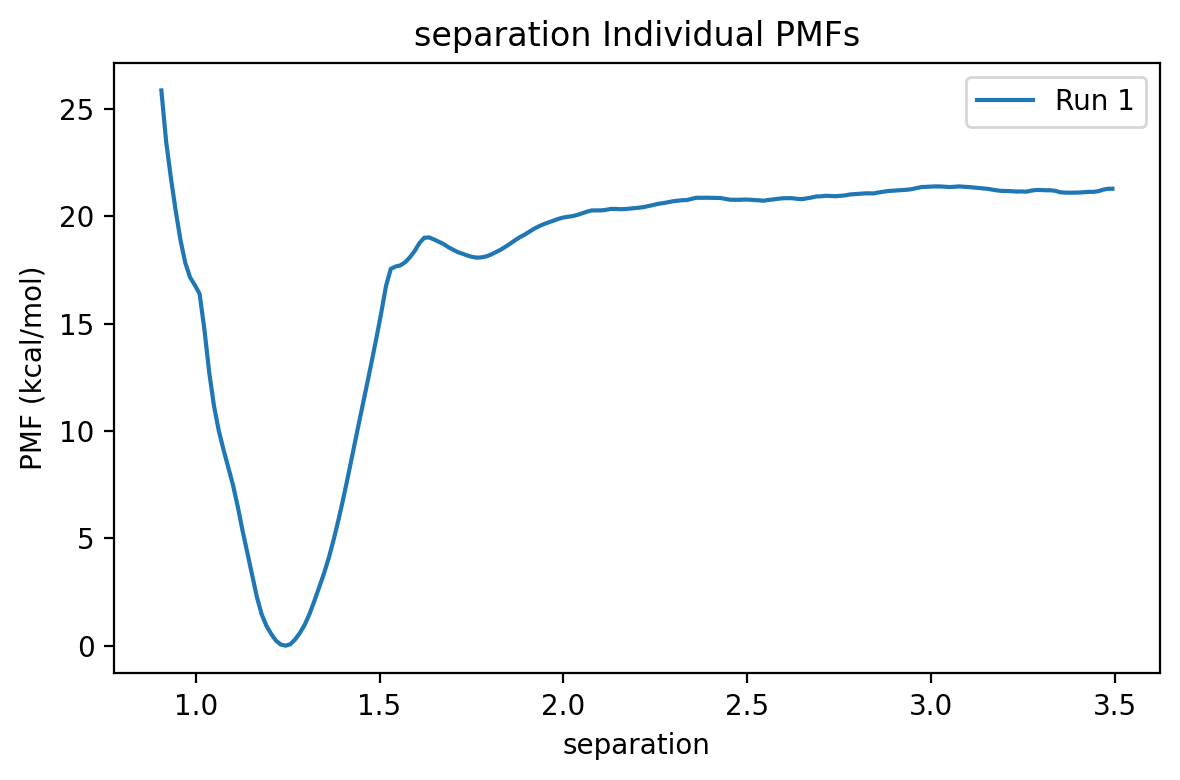

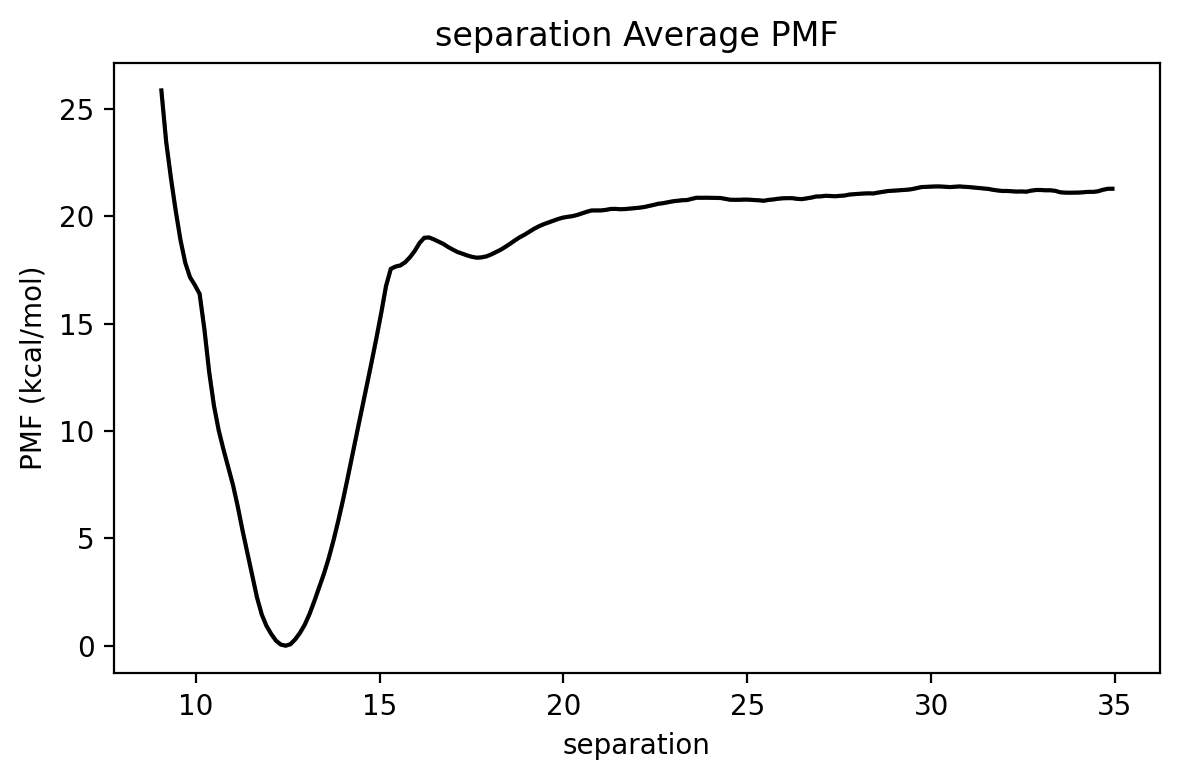

In [4]:
"""Generate the average PMF using WHAM and calculate the corresponding
free energy contribution"""

free_energies = []
r_star = sep_cv_max # sep CV max

runs = [1]

# Select set of calculations to perform WHAM for
free_energy_step, restraint_type, dof, equilibration, sampling_time, plot = [
    'separation', 'backbone', None, 'RED', None, False
]

# Values for WHAM to ignore
ignore_values = []

# Find upper and lower limit for WHAM
resultspath = obtain_dirpath(free_energy_step, restraint_type, dof, None, None, run_number=1)
CV_vals = [float(filename.split('.txt')[0]) for filename in os.listdir(resultspath) if filename.endswith('.txt') and filename not in ('pmf.txt', 'metafile.txt')]
upper_limit = np.max(CV_vals)
lower_limit = np.min(CV_vals)

# Convert to units of nm for RMSD US
if free_energy_step == 'RMSD':
    upper_limit = np.round(upper_limit*0.1, 5)
    lower_limit = np.round(lower_limit*0.1, 5)

# WHAM parameters
wham_params = [lower_limit, upper_limit, 200, 1e-6, 300, 0]

# Set force constant for WHAM metafile, units are kcal mol-1 / nm^2
if free_energy_step == 'separation':
    k = k_sep
elif free_energy_step == 'RMSD':
    k = k_rmsd
elif free_energy_step == 'Boresch':
    k =k_boresch

# Generate positive free energy contribution for bulk state systems
if dof in ['CRBN_len', 'CK1a']:
    unbound = True
else:
    unbound = False

for run_number in runs:

    generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, plot)
    perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
    x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, plot=plot)

    if free_energy_step == 'separation':
        deltaG = SepContribution(x, pmf, r_star)
    elif free_energy_step == 'RMSD':
        deltaG = RMSDContribution(x, pmf, k, unbound)
    elif free_energy_step == 'Boresch':
        deltaG = BoreschContribution(x, pmf, boresch_eq[dof], k)

    free_energies.append(deltaG)

x, av, err = obtain_av_PMF(runs, free_energy_step, restraint_type, dof, equilibration, sampling_time, plot_indiv=True, plot_av=True)

### Analysing the CV samples for a specific window

Applying RED: 100%|██████████| 32/32 [00:00<00:00, 24310.40it/s]


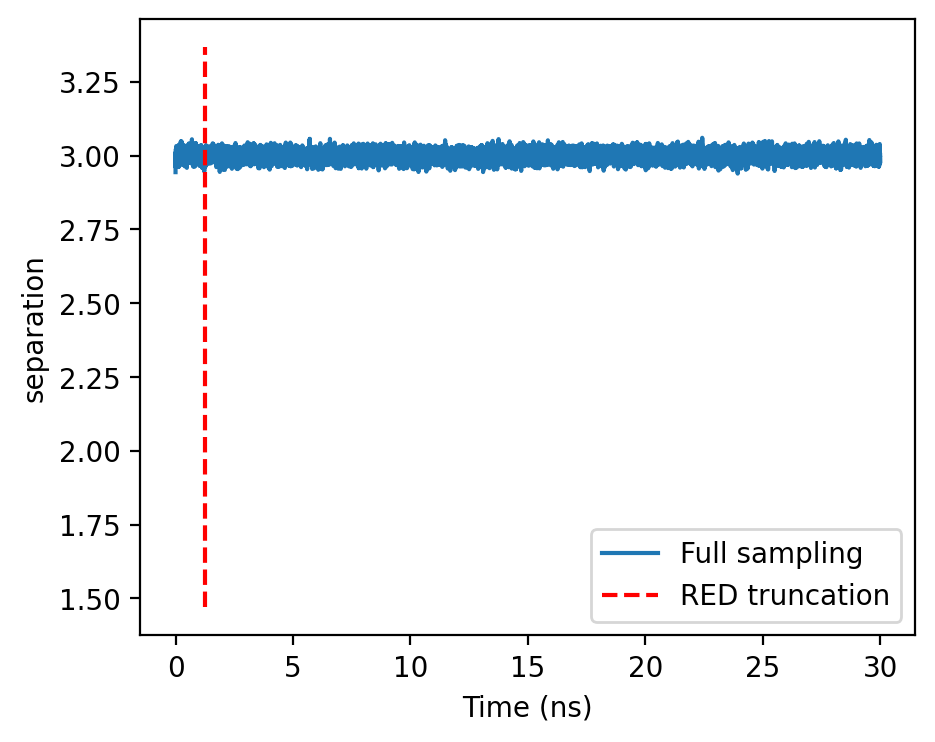

In [35]:
r0 = 3.0
run_number = 1

free_energy_step, restraint_type, dof, equilibration, sampling_time = [
    'separation', 'backbone', None, 'RED', None ]

apply_RED(free_energy_step, restraint_type, None, dof, run_number)
x, y = plot_timeseries(r0, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)

### Checking the RMSD during a specific window

<Axes: xlabel='Steps', ylabel='RMSD (Angstrom)'>

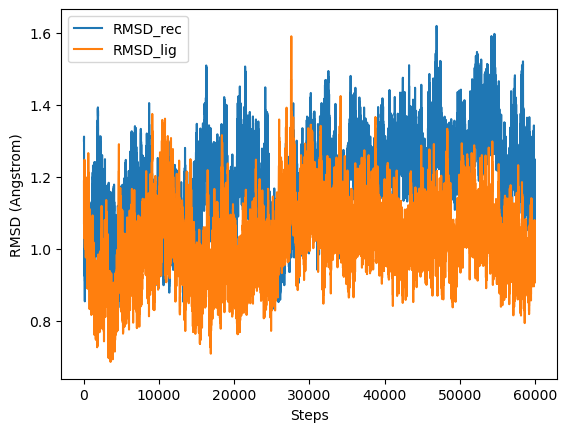

In [40]:
r0 = 3.0
run_number = 1

free_energy_step, restraint_type, dof, equilibration, sampling_time = [
    'separation', 'backbone', None, None, None ]

dirpath = obtain_dirpath(free_energy_step, restraint_type, dof, 
        equilibration, sampling_time, run_number)

df_RMSD = pd.read_csv(f'{dirpath}/{r0}_RMSD.csv')
df_RMSD.plot(x='Steps', y=['RMSD_rec', 'RMSD_lig'], ylabel='RMSD (Angstrom)', legend=True)

## Calculating free energies

Calculate the free energy contributions from the various stages of the thermodynamic cycle (https://pubs.acs.org/doi/10.1021/acs.jcim.7b00695)

In [29]:
"""Separation"""

free_energies = []
r_star = sep_cv_max

runs = [1,2,3]

for n_run in runs:

    wham_params = [0.9, 3.5, 500, 1e-6, 300, 0]

    ignore_values = []

    free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number = [
        'separation', 'backbone', None, 'RED', None, n_run
    ]

    k = k_sep

    generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, False)
    perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
    x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, plot=False)

    deltaG = SepContribution(x, pmf, r_star)

    free_energies.append(deltaG)

# Calculate average and standard error
free_energies = np.array(free_energies)
deltaG_sep = np.average(free_energies)
err_sep = np.std(free_energies)/np.sqrt(len(free_energies))

print(f"\nThe average separation free energy change is {deltaG_sep} kcal/mol")
print(f"The standard error is {err_sep} kcal/mol\n")


Applying RED: 100%|██████████| 39/39 [00:00<00:00, 105330.24it/s]



The average separation free energy change is -20.869503308146395 kcal/mol
The standard error is 1.1242638544953076 kcal/mol



In [55]:
"""RMSD"""

runs = [1,2,3]

# Select which protein to restrain first in the bound state
first_bulk_restraint = 'CRBN_len'

deltaG_RMSD = 0
err_values = []

if first_bulk_restraint == 'CK1a':
    systems = ['CK1a', 'CRBN_len', 'CK1a_only', 'CRBN_lenwithCK1a']
elif first_bulk_restraint == 'CRBN_len':
    systems = ['CK1a', 'CRBN_len', 'CRBN_len_only', 'CK1awithCRBN_len']

# Sum all 
for system in systems:

    # Find upper limit for WHAM
    resultspath = obtain_dirpath(free_energy_step, restraint_type, system, None, None, 1)
    CV_vals = [float(filename.split('.txt')[0]) for filename in os.listdir(resultspath) if filename.endswith('.txt') and filename not in ('pmf.txt', 'metafile.txt')]
    upper_limit = 0.1 * np.max(CV_vals) # Convert to nm

    wham_params = [0.0, np.round(upper_limit, 6), 200, 1e-6, 300, 0]
    ignore_values = []

    free_energy_step, restraint_type, system, equilibration, sampling_time = [
        'RMSD', 'backbone', system, 'RED', None
    ]

    k = k_rmsd # Force constant
    if system in ['CRBN_len', 'CK1a']:
        unbound = True
    else:
        unbound = False

    free_energies = []

    for n_run in runs:

        generate_metafile(free_energy_step, restraint_type, system, equilibration, sampling_time, n_run, k, ignore_values, False)
        perform_WHAM(wham_params, free_energy_step, restraint_type, system, equilibration, sampling_time, n_run)
        x,pmf = obtain_PMF(free_energy_step, restraint_type, system, equilibration, sampling_time, n_run, False)

        deltaG = RMSDContribution(x, pmf, k, unbound)
        free_energies.append(deltaG)

    free_energies = np.array(free_energies)
    deltaG_RMSD += np.average(free_energies)
    err_values.append(np.std(free_energies)/np.sqrt(len(free_energies)))

    print(f"\n{system}: ΔG = {np.round(np.average(free_energies),3)} ± {np.round(np.average(np.std(free_energies)/np.sqrt(len(free_energies))),3)} kcal/mol\n")

# Combine errors
err_values = np.array(err_values)
err_RMSD = np.sqrt(np.sum(np.square(err_values)))

print(f"\nThe average RMSD free energy change ({first_bulk_restraint} restrained first) is {deltaG_RMSD} kcal/mol")
print(f"The standard error is {err_RMSD} kcal/mol\n")

Applying RED: 100%|██████████| 18/18 [00:00<00:00, 62035.72it/s]


Applying RED: 100%|██████████| 18/18 [00:00<00:00, 57456.22it/s]



CK1a: ΔG = 15.967 ± 0.1 kcal/mol



Applying RED: 100%|██████████| 11/11 [00:00<00:00, 93775.09it/s]



CRBN_len: ΔG = 21.27 ± 1.083 kcal/mol



Applying RED: 100%|██████████| 9/9 [00:00<00:00, 18921.67it/s]



CRBN_len_only: ΔG = -18.271 ± 1.155 kcal/mol



Applying RED: 100%|██████████| 9/9 [00:00<00:00, 24013.19it/s]



CK1awithCRBN_len: ΔG = -15.737 ± 0.199 kcal/mol


The average RMSD free energy change (CRBN_len restrained first) is 3.229088356519142 kcal/mol
The standard error is 1.5988068167112872 kcal/mol



In [56]:
"""Boresch"""

runs = [1,2,3]

deltaG_Boresch = 0
err_values = []

dofs = ['thetaA', 'thetaB', 'phiA', 'phiB', 'phiC']

free_energy_step, restraint_type, equilibration, sampling_time= [
    'Boresch', 'backbone', None, None
]

# Sum all 
for dof in dofs:

    free_energies = []

    # Find limits for WHAM
    resultspath = obtain_dirpath(free_energy_step, restraint_type, dof, None, None, run_number)
    CV_vals = [float(filename.split('.txt')[0]) for filename in os.listdir(resultspath) if filename.endswith('.txt') and filename not in ('pmf.txt', 'metafile.txt')]
    upper_limit = np.max(CV_vals)
    lower_limit = np.min(CV_vals)

    wham_params = [np.round(lower_limit, 6), np.round(upper_limit, 6), 100, 1e-6, 300, 0]

    k = k_boresch # Force constant

    for run_number in runs:

        generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, False)
        perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
        x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, False)

        deltaG = BoreschContribution(x, pmf, boresch_eq[dof], k)
        free_energies.append(deltaG)

    free_energies = np.array(free_energies)
    deltaG_Boresch += np.average(free_energies)
    err_values.append(np.std(free_energies)/np.sqrt(len(free_energies)))

    print(f"\n{dof}: ΔG = {np.round(np.average(free_energies),5)} ± {np.round(np.average(np.std(free_energies)/np.sqrt(len(free_energies))),8)} kcal/mol\n")

# Combine errors
err_values = np.array(err_values)
err_Boresch = np.sqrt(np.sum(np.square(err_values)))

print(f"\nThe average Boresch free energy change is {deltaG_Boresch} kcal/mol")
print(f"The standard error is {err_Boresch} kcal/mol\n")


thetaA: ΔG = -0.52617 ± 0.06841351 kcal/mol


thetaB: ΔG = -0.07827 ± 0.00254268 kcal/mol


phiA: ΔG = -0.21358 ± 0.00313621 kcal/mol


phiB: ΔG = -0.39289 ± 0.03944782 kcal/mol


phiC: ΔG = -0.3267 ± 0.00542124 kcal/mol


The average Boresch free energy change is -1.5376083286443127 kcal/mol
The standard error is 0.0792605175534837 kcal/mol



In [57]:
"""Standard state correction"""

r_star = sep_cv_max
deltaG_corr = standard_state_correction(r_star, boresch_eq['thetaA'], boresch_eq['thetaB'], k_boresch)
print(f"The standard state correction is {deltaG_corr} kcal/mol")

The standard state correction is 7.910839164687352 kcal/mol


Combining all the free energy contributions:

In [58]:
"""Binding free energy"""
deltaG_bind = deltaG_RMSD + deltaG_Boresch + deltaG_sep + deltaG_corr
final_error = np.sqrt(np.sum(np.array([err_RMSD+err_Boresch+err_sep])))

print(f"Binding free energy = {deltaG_bind} kcal/mol")
print(f"The standard error is {final_error} kcal/mol")

Binding free energy = -11.267184115584215 kcal/mol
The standard error is 1.6740164840168326 kcal/mol
